# EfficientNet3D

THis file of code is written by Sattiraju Satwik

In [ ]:
import torch

import torch.nn as nn

import torch.nn.functional as F



class EfficientNet3D(nn.Module):

    def __init__(self, input_channels=1, num_classes=2):  # Default input channels to 1

        super(EfficientNet3D, self).__init__()



        # Initial Conv3D layer with dynamic input channels (e.g., 1 for grayscale or 3 for multi-channel)

        self.conv1 = nn.Conv3d(input_channels, 32, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm3d(32)

        self.relu1 = nn.ReLU()



        # Efficient 3D blocks (a few layers for simplicity)

        self.block1 = self._make_block(32, 64)

        self.block2 = self._make_block(64, 128)

        self.block3 = self._make_block(128, 256)



        # Global average pooling layer (to handle variable input size)

        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)



        # Fully connected layers for classification

        self.fc1 = nn.Linear(256, 512)

        self.fc2 = nn.Linear(512, num_classes)  # Output layer changed to 2 classes



        # Dropout for regularization

        self.dropout = nn.Dropout(0.5)



    def _make_block(self, in_channels, out_channels):

        # A helper function to create 3D convolution blocks

        return nn.Sequential(

            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm3d(out_channels),

            nn.ReLU(),

            nn.MaxPool3d(2)

        )



    def forward(self, x):

        # Pass through the initial convolution and the blocks

        x = self.relu1(self.bn1(self.conv1(x)))



        # Block 1, Block 2, Block 3

        x = self.block1(x)

        x = self.block2(x)

        x = self.block3(x)



        # Global average pooling to ensure size consistency

        x = self.global_avg_pool(x)

        x = torch.flatten(x, 1)  # Flatten to (batch_size, num_features)



        # Fully connected layers

        x = self.dropout(F.relu(self.fc1(x)))

        x = self.fc2(x)  # No sigmoid here because we'll use softmax during loss computation



        return x




# Dataset

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class BRATS2021Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Root directory where each patient folder contains segmentation (.pt) and classification.txt.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.patients = sorted(os.listdir(root_dir))  # List of patient folders
        self.transform = transform

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_folder = self.patients[idx]
        patient_dir = os.path.join(self.root_dir, patient_folder)

        # Extract patient ID
        patient_id = patient_folder

        # Define the segmentation file path
        segmentation_path = os.path.join(patient_dir, "segmentation.pt")
        if not os.path.exists(segmentation_path):
            raise FileNotFoundError(f"Segmentation file not found: {segmentation_path}")

        # Load the segmentation file using PyTorch
        segmentation = torch.load(segmentation_path)
        # segmentation = segmentation.permute(1, 2, 3, 0)
        segmentation = segmentation.float() / 255.0  # If the values are in [0, 255]

        # Parse the classification.txt file to get the tumor grade
        classification_file = os.path.join(patient_dir, "classification.txt")
        if not os.path.exists(classification_file):
            raise FileNotFoundError(f"Classification file not found: {classification_file}")

        with open(classification_file, 'r') as f:
            lines = f.readlines()
            tumor_grade = lines[1].strip()  # Assuming second line contains the tumor grade

        # Remove the prefix "Tumor grade: " if present
        tumor_grade = tumor_grade.replace("Tumor grade: ", "").strip()

        # Convert tumor grade to a numeric label (e.g., 0 for low-grade, 1 for high-grade)
        if tumor_grade == "Low-grade":
            tumor_label = 0
        elif tumor_grade == "High-grade":
            tumor_label = 1
        else:
            raise ValueError(f"Unknown tumor grade: {tumor_grade}")

        # Apply transformations if any
        if self.transform:
            segmentation = self.transform(segmentation)

        # Return the segmentation and corresponding tumor label
        return segmentation, tumor_label


# Example transformation (e.g., normalization, resizing)
transform = transforms.Compose([
    # Example: Normalize the data
    transforms.Normalize(mean=[0.5], std=[0.5]),
])




In [ ]:
# Example usage
from torch.utils.data import DataLoader

train_dir = "D:/classification/classification_BraTS2021_train"   # Replace with the actual path

dataset = BRATS2021Dataset(root_dir=train_dir, transform=transform)



# Example DataLoader

train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)



val_dir = "D:/classification/classification_BraTS2021_val"    # Replace with the actual path

dataset = BRATS2021Dataset(root_dir=val_dir, transform=transform)



# Example DataLoader

val_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)


test_dir = "D:/classification/classification_BraTS2021_test"    # Replace with the actual path

dataset = BRATS2021Dataset(root_dir=test_dir, transform=transform)



# Example DataLoader

test_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
for segmentation, tumor_label in train_loader:
    print(f"Segmentation shape: {segmentation.shape}")
    print(f"Tumor label: {tumor_label}")

In [ ]:
img = next(iter(train_loader))

In [ ]:
img[0].shape

# Training Loop

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os

model = EfficientNet3D(input_channels=3, num_classes=2)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

class_weights = torch.tensor([1.0, 2.0])  
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)



# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=100):
    model.train()  # Set model to training mode
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs)  

            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step()  

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = 100 * correct / total

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Learning rate adjustment
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss, correct, total = 0.0, 0, 0

    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    # Optional: Print detailed classification metrics
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=["Low-grade", "High-grade"]))

    return val_loss, val_accuracy


# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=100
)




# plotting

In [ ]:
# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


# Visualization

In [ ]:
import torch
import matplotlib.pyplot as plt
import nibabel as nib  # For loading NIfTI files
import numpy as np

# Example function to load and visualize NIfTI images
def visualize_nifti_image(image_path, label_path=None):
    # Load NIfTI image using nibabel
    img = nib.load(image_path)
    img_data = img.get_fdata()  # Get the data in numpy array format
    
    # Normalize image data to [0, 1] for visualization
    img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))
    
    # If there is a label image, load and visualize it
    if label_path:
        label = nib.load(label_path)
        label_data = label.get_fdata()
        label_data = np.squeeze(label_data)  # Remove extra dimensions
        
        # Plot the original image and the segmentation label (e.g., in slices)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Display the first slice of the image (adjust slice index as needed)
        slice_idx = img_data.shape[2] // 2  # Middle slice
        axes[0].imshow(img_data[:, :, slice_idx], cmap='gray')
        axes[0].set_title("Image Slice")
        
        # Display the corresponding label (if available)
        axes[1].imshow(label_data[:, :, slice_idx], cmap='jet', alpha=0.5)
        axes[1].set_title("Segmentation Label Slice")
        
        plt.show()
    
    else:
        # If no label is provided, just show the image
        plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
        plt.title("Image Slice")
        plt.show()

# Example usage
image_path = 'D:/new_dataset/train/BraTS2021_00000/BraTS2021_00000_seg.nii'  # Path to your NIfTI image
# label_path = 'path_to_label.nii'  # Path to your label (if available)

visualize_nifti_image(image_path)


/tmp/ipykernel_832/1909725513.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_path)


Unique labels in each channel:
Class 1: [1.]
Class 2: [0.]
Class 3: [0.]


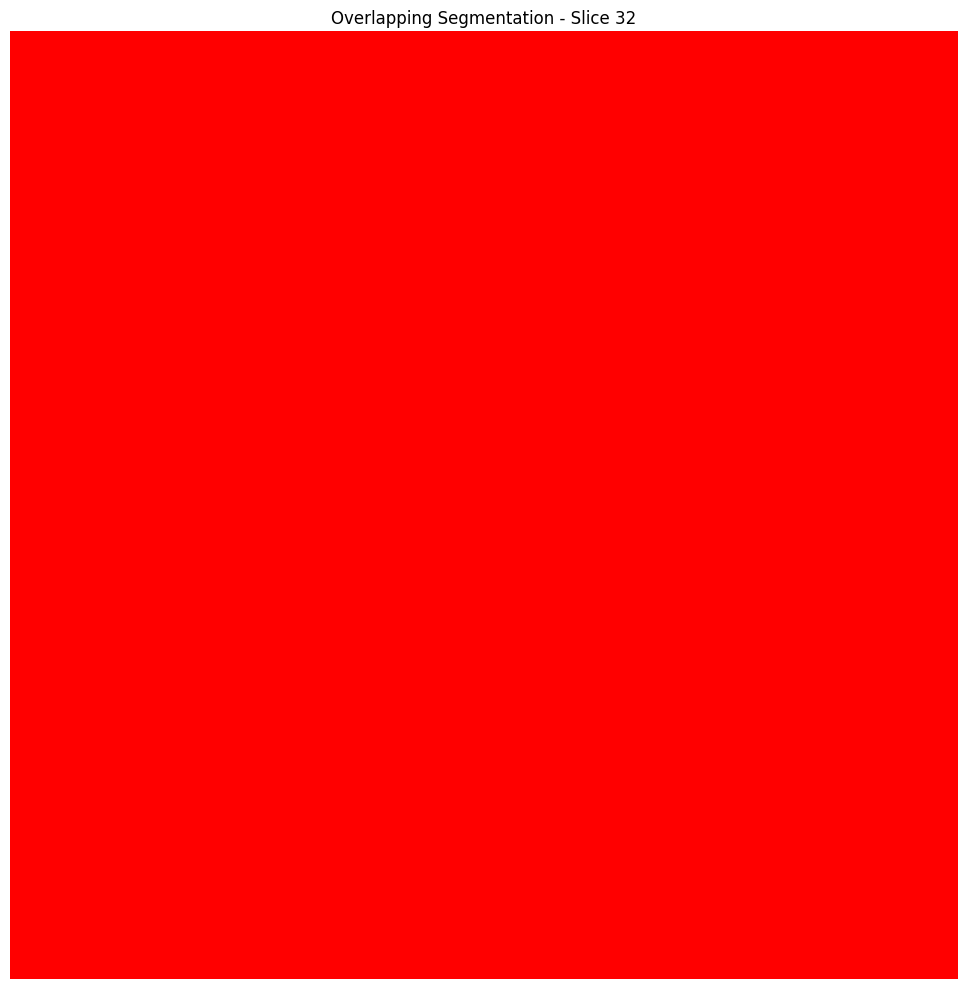

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation_pt(pt_path):
    # Load the tensor from the .pt file
    data = torch.load(pt_path)
    
    # Ensure data is in the correct format (3, H, W, D)
    assert data.shape[0] == 3, "Expected a tensor with 3 classes (channels)"
    
    # Normalize the data if necessary (for visualization purposes)
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))  # Normalize to 0-1

    # Convert to numpy array for visualization
    data = data.cpu().numpy()  # Ensure the tensor is on CPU for conversion

    # Print the unique labels in each channel
    print("Unique labels in each channel:")
    for i in range(3):
        unique_labels = np.unique(data[i])  # Get unique values in the channel
        print(f"Class {i+1}: {unique_labels}")

    # Select the middle slice for visualization
    slice_idx = data.shape[2] // 2  # Middle slice along the Z-axis
    
    # Create the plot
    plt.figure(figsize=(10, 10))

    # Initialize an empty image for overlay
    overlay_image = np.zeros((data.shape[1], data.shape[2], 3))  # RGB image to hold the overlay

    # Define colors for each class (you can customize these colors)
    colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # Red, Green, Blue for 3 classes

    # Iterate over each class and apply the class-specific color
    for i in range(3):
        class_mask = (data[i, :, :, slice_idx] > 0.5).astype(np.uint8)  # Apply threshold
        # Apply the color to the mask using transparency (alpha blending)
        overlay_image[:, :, 0] += class_mask * colors[i][0]  # Red channel
        overlay_image[:, :, 1] += class_mask * colors[i][1]  # Green channel
        overlay_image[:, :, 2] += class_mask * colors[i][2]  # Blue channel
    
    # Plot the overlay image using 'jet' colormap for class overlap visualization
    plt.imshow(overlay_image)
    plt.title(f"Overlapping Segmentation - Slice {slice_idx}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
pt_path = '/kaggle/input/classification/classification_BraTS2021_val/BraTS2021_00251/segmentation.pt'  # Path to your .pt file
visualize_segmentation_pt(pt_path)


/tmp/ipykernel_832/3702842197.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_path)


Tensor shape: torch.Size([64, 64, 64, 4])


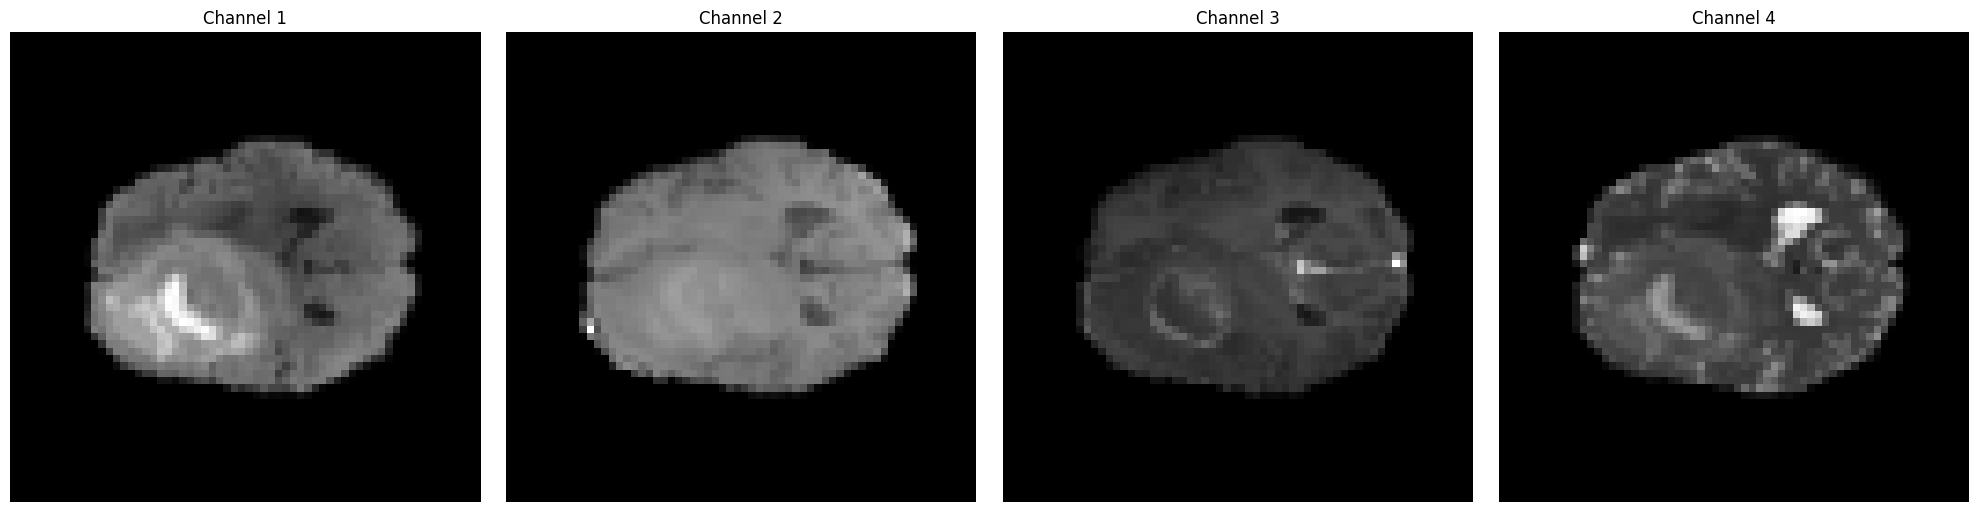

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_modalities_pt(pt_path):
    # Load the tensor from the .pt file
    data = torch.load(pt_path)
    
    # Print the shape of the tensor to verify it's (64, 64, 64, 4)
    print("Tensor shape:", data.shape)
    
    # Check if the data has 4 channels
    assert data.shape[-1] == 4, "Expected a tensor with 4 channels"
    
    # Normalize the data for visualization
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))  # Normalize to 0-1
    
    # Select the middle slice along the Z-axis (index 32 in a 64x64x64 image)
    slice_idx = data.shape[0] // 2  # Middle slice along the Z-axis
    
    # Plot the slices for each of the 4 channels
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i in range(4):
        # Extract the slice for the i-th channel
        channel_data = data[:, :, slice_idx, i].cpu().numpy()  # Convert to numpy for visualization
        
        # Show the slice for the current channel
        axes[i].imshow(channel_data, cmap='gray')
        axes[i].set_title(f"Channel {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
pt_path =  '/kaggle/input/classification/classification_BraTS2021_train/BraTS2021_00002/modalities.pt' # Path to your .pt file
visualize_modalities_pt(pt_path)
